# Theory


Implicit reparametrization gradients

Forward pass: sample $z \sim q_{\phi}(z)$

Backward pass: 
1. set $\nabla_{\phi} z = -(\nabla_zS_{\phi}(z))^{-1}\nabla_{\phi}S_{\phi}(z)$
2. set $\nabla_{\phi} f(z) = \nabla_z f(z) \nabla_{\phi} z$

#Experiments


In [1]:
## Standard libraries
import os
import json
import math
import numpy as np
from scipy import spatial
import pickle
import scipy

## Imports for plotting
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.auto import tqdm

## JAX
import jax
import jax.numpy as jnp
from jax import random, vmap, custom_jvp, grad
from jax.scipy.special import gammaln, digamma

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## PyTorch Data Loading
import torch
import torch.utils.data as data
import torchvision
from torchvision.datasets import CIFAR10

print("Device:", jax.devices()[0])

Device: gpu:0


##Data

We will work with MNIST digits. Let's download dataset and visualize several samples

In [2]:
!gdown --id 1hExV0C8wQWsrA4HfRTq9y9rMo7Pjd9Gw

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1hExV0C8wQWsrA4HfRTq9y9rMo7Pjd9Gw
To: /content/mnist.pkl
100% 188M/188M [00:02<00:00, 92.5MB/s]


In [3]:
def load_pickle(path, flatten=False, binarize=False):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    train_data = data['train'].astype('float32')
    test_data = data['test'].astype('float32')
    if binarize:
        train_data = (train_data > 128).astype('float32')
        test_data = (test_data > 128).astype('float32')
    else:
        train_data = train_data / 255.
        test_data = test_data / 255.
        
    if flatten:
        train_data = train_data.reshape(len(train_data.shape[0]), -1)
        test_data = test_data.reshape(len(train_data.shape[0]), -1)
    return train_data, test_data

In [4]:
train_data, test_data = load_pickle('mnist.pkl', flatten=False, binarize=False)

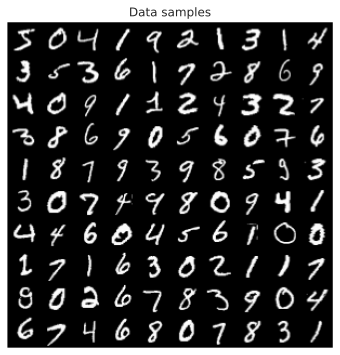

In [6]:
grid_samples = make_grid(torch.from_numpy(train_data[:100]).permute(0, 3, 1, 2), nrow=10)
grid_img = grid_samples.permute(1, 2, 0)
figsize = (6, 6)
plt.figure(figsize=figsize)
plt.title('Data samples')
plt.imshow(grid_img)
plt.axis('off')
plt.show()

In [ ]:
train_data[0].shape #shape of one image

(28, 28, 1)

In [5]:
# For visualization, we might want to map JAX or numpy tensors back to PyTorch
def jax_to_torch(imgs):
    imgs = jax.device_get(imgs)
    imgs = torch.from_numpy(imgs.astype(np.float32))
    imgs = imgs.permute(0, 3, 1, 2)
    return imgs

# We need to stack the batch elements
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True, pin_memory=True, num_workers=2, collate_fn=numpy_collate, persistent_workers=True)
test_loader = data.DataLoader(test_data, batch_size=64, shuffle=False, drop_last=False, num_workers=2, collate_fn=numpy_collate)

In [ ]:
next(iter(train_loader)).shape #batch shape

(64, 28, 28, 1)

## Model 

In [6]:
class Encoder(nn.Module):
    c_hid : int
    latent_dim : int

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=self.c_hid, kernel_size=(3, 3), strides=2)(x)  # 28x28 => 14x14
        x = nn.gelu(x)
        x = nn.Conv(features=self.c_hid, kernel_size=(3, 3))(x)
        x = nn.gelu(x)
        x = nn.Conv(features=2*self.c_hid, kernel_size=(3, 3), strides=2)(x)  # 12x12 => 6x6
        x = nn.gelu(x)
        x = nn.Conv(features=2*self.c_hid, kernel_size=(3, 3))(x)
        x = nn.gelu(x)
        x = nn.Conv(features=2*self.c_hid, kernel_size=(3, 3), strides=2)(x)  # 6x6 => 3x3
        x = nn.gelu(x)
        x = x.reshape(x.shape[0], -1)  # Image grid to single feature vector
        mean = nn.Dense(features=self.latent_dim)(x)
        log_std = nn.Dense(features=self.latent_dim)(x)
        return mean, log_std

In [6]:
## Test encoder implementation
# Random key for initialization
rng = random.PRNGKey(0)
# Example images as input
imgs = next(iter(train_loader))
# Create encoder
encoder = Encoder(c_hid=16, latent_dim=16)
# Initialize parameters of encoder with random key and images
params = encoder.init(rng, imgs)['params']
# Apply encoder with parameters on the images
out = encoder.apply({'params': params}, imgs)
print(out[0].shape, out[1].shape)

del out, encoder, params

(64, 16) (64, 16)


In [7]:
class Decoder(nn.Module):
    c_out : int
    c_hid : int
    latent_dim : int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=2*16*self.c_hid)(x)
        x = nn.gelu(x)
        x = x.reshape(x.shape[0], 4, 4, -1)
        x = nn.ConvTranspose(features=2*self.c_hid, kernel_size=(3, 3), strides=(2, 2))(x)
        x = nn.gelu(x)
        x = nn.Conv(features=2*self.c_hid, kernel_size=(3, 3))(x)
        x = nn.gelu(x)
        x = nn.ConvTranspose(features=self.c_hid, kernel_size=(3, 3), strides=(2, 2))(x)
        x = nn.gelu(x)
        x = nn.Conv(features=self.c_hid, kernel_size=(3, 3), padding='VALID')(x)
        x = nn.gelu(x)
        x = nn.ConvTranspose(features=self.c_out, kernel_size=(3, 3), strides=(2, 2))(x)
        return x

In [126]:
## Test decoder implementation
# Random key for initialization
rng = random.PRNGKey(0)
# Example latents as input
rng, lat_rng = random.split(rng)
latents = random.normal(lat_rng, (64, 16))
# Create decoder
decoder = Decoder(c_hid=16, latent_dim=16, c_out=1)
# Initialize parameters of decoder with random key and latents
rng, init_rng = random.split(rng)
params = decoder.init(init_rng, latents)['params']
# Apply decoder with parameters on the images
out = decoder.apply({'params': params}, latents)
print(out.shape)

del out, decoder, params

(64, 28, 28, 1)


##Vanilla VAE

In [53]:
class ExplicitVAE(nn.Module):
    c_hid: int
    latent_dim : int

    def setup(self):
      self.encoder = Encoder(c_hid=self.c_hid, latent_dim=self.latent_dim)
      self.decoder = Decoder(c_hid=self.c_hid, latent_dim=self.latent_dim, c_out=1)

    def __call__(self, x, rng):
      mean, log_std = self.encoder(x)
      z = mean + jnp.exp(log_std) * jax.random.normal(rng, mean.shape)
      logits = self.decoder(z)
      return mean, log_std, logits

In [ ]:
## Test Autoencoder implementation
# Random key for initialization
rng = random.PRNGKey(0)
# Example images as input
imgs = next(iter(train_loader))
# Create encoder
autoencoder = ExplicitVAE(c_hid=16, latent_dim=16)
# Initialize parameters of encoder with random key and images
params = autoencoder.init(rng, imgs, rng)['params']
# Apply encoder with parameters on the images
out, _, _ = autoencoder.apply({'params': params}, imgs, rng)
print(out.shape)

del out, autoencoder, params

(64, 16)


## Loss function

In [8]:
def normal_nll(x: jnp.ndarray, logits: jnp.ndarray):
  """Calculate negative log likelihood for gaussian distribution with given mean and standart variance
  Args:
      x: sample from dataset
      logits: mean vector of gaussian distribution
  """
  x = jnp.reshape(x, (x.shape[0], -1))
  logits = jnp.reshape(logits, (logits.shape[0], -1))

  return jnp.sum((x - logits)**2 / 2 + 0.5 * jnp.log(2 * math.pi), axis=-1)


def kl_gaussian(mean: jnp.ndarray, log_std: jnp.ndarray):
  """Calculate KL divergence between given and standard gaussian distributions.
  Args:
      mean: mean vector of the first distribution
      var: diagonal vector of covariance matrix of the first distribution
  """
  var = jnp.exp(log_std) ** 2
  return 0.5 * jnp.sum(-log_std - 1.0 + var + jnp.square(mean), axis=-1)

def elbo(params, model, rng_key, batch): 
    """Negative ELBO: -E_p[log(x)] + KL(d||q)"""
    mean, log_std, logits = model.apply({'params': params}, batch, rng_key)

    log_likelihood = normal_nll(batch, logits)
    kl = kl_gaussian(mean, log_std)

    elbo = log_likelihood + kl

    return jnp.mean(elbo)

##Trainer Module

In [9]:
class TrainerModule:
    def __init__(self, model, lr=1e-3, seed=42):
        super().__init__()
        self.lr = lr
        self.seed = seed
        self.model = model

        # Prepare logging
        self.exmp_imgs = next(iter(test_loader))

        # Create jitted training and eval functions
        self.create_functions()
        # Initialize model
        self.init_model()

    def create_functions(self):
        # Training function
        def train_step(state, batch, rng_key):
            loss_fn = lambda params: elbo(params, self.model, rng_key, batch)
            loss, grads = jax.value_and_grad(loss_fn)(state.params)  # Get loss and gradients for loss
            state = state.apply_gradients(grads=grads)  # Optimizer update step
            return state, loss
        self.train_step = jax.jit(train_step)
        # Eval function
        def eval_step(state, batch, rng_key):
            return elbo(state.params, self.model, rng_key, batch)
        self.eval_step = jax.jit(eval_step)

    def init_model(self):
        # Initialize model
        rng = jax.random.PRNGKey(self.seed)
        rng, init_rng, exmp_rng = jax.random.split(rng, 3)
        params = self.model.init(init_rng, self.exmp_imgs, exmp_rng)['params']
        # Initialize optimizer
        optimizer = optax.chain(
            optax.clip(1.0),  # Clip gradients at 1
            optax.adam(0.001)
        )
        # Initialize training state
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=optimizer)

    def train_model(self, rng, num_epochs=500):
        # Train model for defined number of epochs
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            rng, epoch_rng = random.split(rng)
            self.train_epoch(epoch_idx, epoch_rng)

    def train_epoch(self, epoch, rng):
        # Train model for one epoch, and log avg loss
        losses = []
        for batch in train_loader:
            rng, iter_rng = random.split(rng)
            self.state, loss = self.train_step(self.state, batch, iter_rng)
            losses.append(loss)
        losses_np = np.stack(jax.device_get(losses))
        avg_loss = losses_np.mean()
        print(avg_loss)

    def eval_model(self, data_loader, rng):
        # Test model on all images of a data loader and return avg loss
        losses = []
        batch_sizes = []
        for batch in data_loader:
            rng, iter_rng = random.split(rng)
            loss = self.eval_step(self.state, batch, iter_rng)
            losses.append(loss)
            batch_sizes.append(batch[0].shape[0])
        losses_np = np.stack(jax.device_get(losses))
        batch_sizes_np = np.stack(batch_sizes)
        avg_loss = (losses_np * batch_sizes_np).sum() / batch_sizes_np.sum()
        return avg_loss

In [55]:
model = ExplicitVAE(c_hid=16, latent_dim=16)
trainer = TrainerModule(model)
trainer.train_model(num_epochs=10, rng=jax.random.PRNGKey(10))

  0%|          | 0/10 [00:00<?, ?it/s]

739.94495
735.38666
734.72784
734.36774
734.12067
733.94525
733.8258
733.7011
733.593
733.5108


In [57]:
trainer.model_bd = trainer.model.bind({'params': trainer.state.params})

##Visualization

###Generation

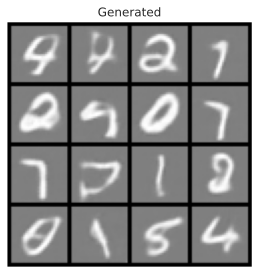

In [76]:
z = jax.random.normal(rng, (16, 16)) #random noise
imgs = trainer.model_bd.decoder(z) 

# Plotting
imgs = jax_to_torch(imgs)
grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(7,4.5))
plt.title(f"Generated")
plt.imshow(grid)
plt.axis('off')
plt.show()

### Reconstruction

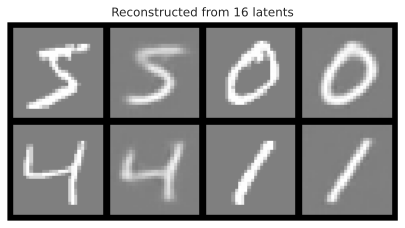

In [59]:
input_imgs = train_data[:4]
_, _, reconst_imgs = trainer.model_bd(input_imgs, rng=jax.random.PRNGKey(10))
imgs = np.stack([input_imgs, reconst_imgs], axis=1).reshape(-1, *reconst_imgs.shape[1:])

# Plotting
imgs = jax_to_torch(imgs)
grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(7,4.5))
plt.title(f"Reconstructed from 16 latents")
plt.imshow(grid)
plt.axis('off')
plt.show()

## Implicit Reparametrization

### Implicit reparametrization of Gamma distribution

In [10]:
from jax import jit

In [11]:
def egrad(g):
  def wrapped(x, *rest):
    y, g_vjp = jax.vjp(lambda x: g(x, *rest), x)
    x_bar, = g_vjp(jnp.ones_like(y))
    return x_bar
  return wrapped

gamma_grad = egrad(jax.scipy.special.gammainc)

@custom_jvp
def implicit_reparametrization(log_alpha, rng):
  return jax.random.gamma(rng, jnp.exp(log_alpha))

@implicit_reparametrization.defjvp
def implicit_reparametrization_jvp(primals, tangents):
  log_alpha, rng = primals
  alpha_tangent, _ = tangents
  ans = implicit_reparametrization(log_alpha, rng)

  alpha = jnp.exp(log_alpha)
  pdf = jax.scipy.stats.gamma.pdf(ans, alpha)
  return ans, -gamma_grad(alpha, ans) * alpha_tangent

In [12]:
@jit
def rep(log_alpha, rng):
  impl_rep = lambda a: implicit_reparametrization(a, rng)
  return vmap(impl_rep)(log_alpha)

###Update losses

In [13]:
def kl_gamma(log_alpha: jnp.ndarray, log_beta: jnp.ndarray) -> jnp.ndarray:
    """Calculate KL divergence between given and standard gamma distributions.
    """
    alpha = jnp.exp(log_alpha)
    beta = jnp.exp(log_beta)
    return jnp.sum((alpha - 1)*digamma(alpha) - gammaln(alpha) + log_beta + alpha*(1/beta - 1), axis=-1)

def elbo(params, model, rng_key, batch):
    """Negative ELBO"""
    log_alpha, log_beta, logits = model.apply({'params': params}, batch, rng_key)

    log_likelihood = normal_nll(batch, logits)
    kl = kl_gamma(log_alpha, log_beta)
    elbo = log_likelihood + kl

    return jnp.mean(elbo)

### Model

In [14]:
class ImplicitVAE(nn.Module):
    c_hid: int
    latent_dim : int

    def setup(self):
        self.encoder = Encoder(c_hid=self.c_hid, latent_dim=self.latent_dim)
        self.decoder = Decoder(c_hid=self.c_hid, latent_dim=self.latent_dim, c_out=1)

    def __call__(self, x, rng):
        log_alpha, log_beta = self.encoder(x)
        log_alpha = jnp.clip(log_alpha, -15, 2)
        log_beta = jnp.clip(log_beta, -15, 2)

        z = rep(log_alpha, rng) / jnp.exp(log_beta)
        logits = self.decoder(z)
        return log_alpha, log_beta, logits

In [15]:
model = ImplicitVAE(c_hid=16, latent_dim=16)
trainer = TrainerModule(model)
trainer.train_model(num_epochs=20, rng=jax.random.PRNGKey(10))

  0%|          | 0/20 [00:00<?, ?it/s]

747.53546
746.4115
746.1908
746.30835
746.18134
746.1305
746.0285
746.1346
746.0834
745.9539
746.0154
746.0949
746.0069
745.9736
746.0536
745.9033
745.88495
746.0589
745.91003
746.0021


In [16]:
trainer.model_bd = trainer.model.bind({'params': trainer.state.params})

##Visualization

###Generation

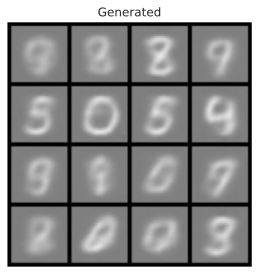

In [18]:
rng=jax.random.PRNGKey(2)
z = jax.random.gamma(rng, jnp.ones((16, 16)), (16, 16)) #random noise
imgs = trainer.model_bd.decoder(z) 

# Plotting
imgs = jax_to_torch(imgs)
grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(7,4.5))
plt.title(f"Generated")
plt.imshow(grid)
plt.axis('off')
plt.show()

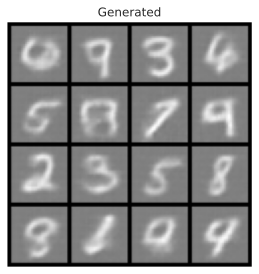

In [65]:
rng=jax.random.PRNGKey(2)
z = jax.random.gamma(rng, jnp.ones((16, 16)), (16, 16)) #random noise
imgs = trainer.model_bd.decoder(z) 

# Plotting
imgs = jax_to_torch(imgs)
grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(7,4.5))
plt.title(f"Generated")
plt.imshow(grid)
plt.axis('off')
plt.show()

### Reconstruction

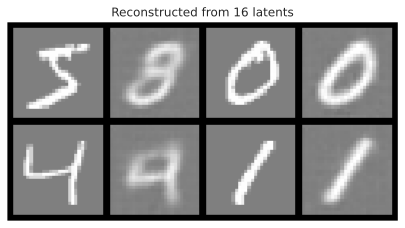

In [66]:
input_imgs = train_data[:4]
_, _, reconst_imgs = trainer.model_bd(input_imgs, rng=jax.random.PRNGKey(10))
imgs = np.stack([input_imgs, reconst_imgs], axis=1).reshape(-1, *reconst_imgs.shape[1:])

# Plotting
imgs = jax_to_torch(imgs)
grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(7,4.5))
plt.title(f"Reconstructed from 16 latents")
plt.imshow(grid)
plt.axis('off')
plt.show()

### Different implementation

In [56]:
def implicit_reparametrization(log_alpha, rng):
  return jax.random.gamma(rng, jnp.exp(log_alpha))

class ImplicitVAE(nn.Module):
    c_hid: int
    latent_dim : int

    def setup(self):
        self.encoder = Encoder(c_hid=self.c_hid, latent_dim=self.latent_dim)
        self.decoder = Decoder(c_hid=self.c_hid, latent_dim=self.latent_dim, c_out=1)

    def __call__(self, x, rng):
        log_alpha, log_beta = self.encoder(x)

        z = implicit_reparametrization(log_alpha, rng) / (jnp.exp(log_beta) + 1e-8)
        logits = self.decoder(z)
        return log_alpha, log_beta, logits

In [57]:
model = ImplicitVAE(c_hid=16, latent_dim=16)
trainer = TrainerModule(model)
trainer.train_model(num_epochs=10, rng=jax.random.PRNGKey(10))

  0%|          | 0/10 [00:00<?, ?it/s]

744.4832
741.7158
741.1168
740.7952
740.5946
740.4611
740.2932
740.21906
740.12354
740.0456


In [58]:
trainer.model_bd = trainer.model.bind({'params': trainer.state.params})

##Visualization

###Generation

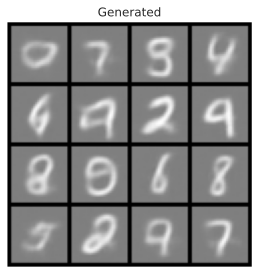

In [59]:
rng=jax.random.PRNGKey(2)
z = jax.random.gamma(rng, jnp.ones((16, 16)), (16, 16)) #random noise
imgs = trainer.model_bd.decoder(z) 

# Plotting
imgs = jax_to_torch(imgs)
grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(7,4.5))
plt.title(f"Generated")
plt.imshow(grid)
plt.axis('off')
plt.show()

### Reconstruction

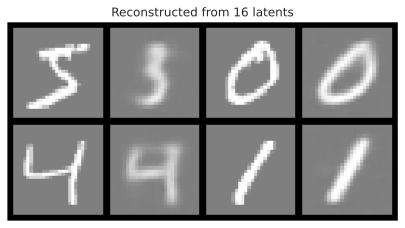

In [60]:
input_imgs = train_data[:4]
_, _, reconst_imgs = trainer.model_bd(input_imgs, rng=jax.random.PRNGKey(10))
imgs = np.stack([input_imgs, reconst_imgs], axis=1).reshape(-1, *reconst_imgs.shape[1:])

# Plotting
imgs = jax_to_torch(imgs)
grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(7,4.5))
plt.title(f"Reconstructed from 16 latents")
plt.imshow(grid)
plt.axis('off')
plt.show()

**Results**

In this case vanilla vae performs better than implicit reparametrization with gamma distribution. However, it is interesting that results of these two models are very different. Implicit reparametrization has big potential because it allows us to experiment with various complex distributions